# 여기부터 실행

- 폴더를 경로에 추가해서 사용

In [1]:
import sys
import os 

# "models" 폴더를 python 경로에 추가
# 초기 디렉토리를 저장
initial_dir = os.getcwd()
os.chdir('higan')

models_path = os.path.abspath("models")
if models_path not in sys.path:
    sys.path.append(models_path)

os.chdir(initial_dir)

In [2]:
import sys
import os 

# "utils" 폴더를 python 경로에 추가
# 초기 디렉토리를 저장
initial_dir = os.getcwd()
os.chdir('higan')

models_path = os.path.abspath("utils")
if models_path not in sys.path:
    sys.path.append(models_path)

os.chdir(initial_dir)

# 변수 및 필요 함수 로드

In [3]:
import io
import sys
import os
import numpy as np
from tqdm import tqdm
import torch

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
from sklearn.cluster import DBSCAN
from scipy.ndimage import maximum_position

# models 내부 모듈 import
from helper import build_generator

from logger import setup_logger
from editor import get_layerwise_manipulation_strength
from editor import manipulate

# Gradients 저장 변수
gradients = {}


def build_model(model_name, logger=None): # exec_init_model
  """Builds the generator by model name."""
  model = build_generator(model_name, logger=logger)
  return model
# build_model -> helper.py(build_generator) -> 
# -> stylegan_generator.py{class StyleGANGenerator(BaseGenerator))} ->
# -> base_generator.py(BaseGenerator) -> class BaseGenerator(def load)

# latent_code를 반환해주는 함수
def sample_codes(model, num, seed=0, w1k_code=None):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  if w1k_code is None:
    codes = generator.easy_sample(num)
    latent_codes = model.easy_sample(num=num, latent_space_type='w')
  else:
    latent_codes = w1k_code[np.random.randint(0, w1k_code.shape[0], num)]
  latent_codes = model.easy_synthesize(latent_codes=latent_codes,
                                       latent_space_type='w',
                                       generate_style=False,
                                       generate_image=False)['wp']
  return latent_codes


# Boundary 파일 로드 함수 정의
def load_boundary(boundary_name, base_dir='boundaries/stylegan_bedroom'):
    path = os.path.join(base_dir, boundary_name)
    boundary_file = np.load(path, allow_pickle=True).item()
    boundary = boundary_file['boundary']
    manipulate_layers = boundary_file['meta_data']['manipulate_layers']
    return boundary, manipulate_layers

# Grad-CAM 계산 함수
def calculate_grad_cam(feature_map, gradients):
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # [C]
    grad_cam = torch.zeros_like(feature_map[0, 0])
    for i in range(feature_map.shape[1]):
        grad_cam += pooled_gradients[i] * feature_map[0, i]
    grad_cam = torch.relu(grad_cam)  # ReLU 적용
    grad_cam -= grad_cam.min()  # 정규화
    grad_cam /= grad_cam.max()
    return grad_cam.detach().cpu().numpy()

# Heatmap을 원본 이미지에 겹쳐서 시각화하는 함수
def overlay_heatmap_on_image(image, grad_cam, alpha=0.5, cmap='jet'):
    grad_cam_resized = cv2.resize(grad_cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(grad_cam_resized * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    if image.max() > 1:
        image = image / 255.0
    overlayed_image = alpha * heatmap / 255.0 + (1 - alpha) * image
    overlayed_image = np.clip(overlayed_image, 0, 1)
    return overlayed_image

# Heatmap 클러스터링 함수 (DBSCAN 활용)
def cluster_heatmap_with_dbscan(heatmap, eps=3, min_samples=5, prob_threshold=0.5):
    high_prob_indices = np.argwhere(heatmap >= prob_threshold)
    high_prob_values = heatmap[heatmap >= prob_threshold]

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_prob_indices)
    labels = db.labels_

    clusters = {}
    for cluster_id in set(labels):
        if cluster_id == -1:  # Noise 처리
            continue
        cluster_points = high_prob_indices[labels == cluster_id]
        cluster_values = high_prob_values[labels == cluster_id]
        clusters[cluster_id] = (cluster_points, cluster_values)

    return clusters

# Hook 설정 함수
def setup_hooks(generator, target_layers):
    hooks = []

    def forward_hook(module, input, output):
        module.feature_map = output

    def backward_hook(module, grad_in, grad_out):
        gradients[module.name] = grad_out[0]

    for layer_idx in target_layers:
        layer = getattr(generator.net.synthesis, f'layer{layer_idx}')
        layer.name = f'layer{layer_idx}'
        hooks.append(layer.register_forward_hook(forward_hook))
        hooks.append(layer.register_backward_hook(backward_hook))

    return hooks

# Hook 제거 함수
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()
        
# w1k_code = np.load('order_w_1k.npy')


# input_data 읽어오기

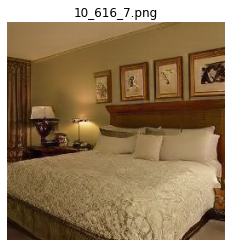

Num Sample : 10
Noise Seed : 616
Image Num : 7


In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 디렉토리 경로
directory_path = './input_data'

# 결과를 저장할 리스트
num_sample_list = []
noise_seed_list = []
image_num_list = []

# 디렉터리 내 파일 순회
for file_name in os.listdir(directory_path):
    # PNG 파일만 처리
    if file_name.endswith('.png'):
        file_path = os.path.join(directory_path, file_name)
        # 이미지 열기
        img = Image.open(file_path)
        # 출력
        plt.figure()
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')
        plt.show()

        # 파일 이름에서 숫자 추출
        try:
            # 파일 이름에서 숫자 분리 (예: 100_234_6.png -> [100, 234, 6])
            num_sample, noise_seed, image_num = map(int, file_name.rstrip('.png').split('_'))

            # 각 숫자를 리스트에 저장
            num_sample_list.append(num_sample)
            noise_seed_list.append(noise_seed)
            image_num_list.append(image_num)
        except ValueError:
            print(f"Invalid file name format: {file_name}")


num_samples = num_sample_list[0]
noise_seed = noise_seed_list[0]
image_num = image_num_list[0]

input_data = [num_samples, noise_seed, image_num]

print("Num Sample :", num_samples)
print("Noise Seed :", noise_seed)
print("Image Num :", image_num)

# inference_sub

In [5]:
# Generator 모델 로드
from stylegan_generator import StyleGANGenerator
from model_settings import MODEL_POOL

 
model_info_dict = {}

def exec_init_model():
    indoor_model_name = "stylegan_bedroom"
    model = build_model(indoor_model_name)
    model_info_dict = {
        "model": model
    }
    return model_info_dict

def exec_inference_dataframe(input_data, model_info_dict):
    # 학습 모델, latent space 준비
    indoor_model = model_info_dict['model']
    w1k_code = np.load('order_w_1k.npy')
    indoor_model_name = 'stylegan_bedroom'
    attribute_name = 'indoor_lighting'
    
    # input_data(이미지) 불러오기
    # input_data[0] : num_sample, input_data[1] : noise_seed, input_data[2] : image_num
    indoor_latent_codes = sample_codes(indoor_model, input_data[0], input_data[1], w1k_code=w1k_code)
    synthesis_kwargs = {'latent_space_type': 'wp'}
    images = indoor_model.easy_synthesize(indoor_latent_codes, **synthesis_kwargs)['image']
    
    # boundary통한 latent code 조작으로 laten_code1 생성
    path = f'boundaries/{indoor_model_name}/{attribute_name}_boundary.npy'
    #print(f'Loading boundary from {path}')
    try:
      boundary_file = np.load(path, allow_pickle=True).item()
      boundary = boundary_file['boundary']
      manipulate_layers = boundary_file['meta_data']['manipulate_layers']
    except ValueError:
      boundary = np.load(path)
      if attribute_name == 'view':
        manipulate_layers = '0-4'
      else:
        manipulate_layers = '6-11'
        
    if attribute_name == 'view':
      strength = [1.0 for _ in range(indoor_model.num_layers)]
    else:
      strength = get_layerwise_manipulation_strength(
        indoor_model.num_layers, indoor_model.truncation_psi, indoor_model.truncation_layers)

    distance = -3 # {min:-3.0, max:3.0, step:0.1}
    latent_codes1 = manipulate(latent_codes=indoor_latent_codes,
                         boundary=boundary,
                         start_distance=0,
                         end_distance=distance,
                         step=2,
                         layerwise_manipulation=True,
                         num_layers=indoor_model.num_layers,
                         manipulate_layers=manipulate_layers,
                         is_code_layerwise=True,
                         is_boundary_layerwise=False,
                         layerwise_manipulation_strength=strength)
    distance = 3 #{min:-3.0, max:3.0, step:0.1}
    latent_codes2 = manipulate(latent_codes=indoor_latent_codes,
                         boundary=boundary,
                         start_distance=0,
                         end_distance=distance,
                         step=2,
                         layerwise_manipulation=True,
                         num_layers=indoor_model.num_layers,
                         manipulate_layers=manipulate_layers,
                         is_code_layerwise=True,
                         is_boundary_layerwise=False,
                         layerwise_manipulation_strength=strength)
    
    # layer별 feature map 확인 위해 generator load
    model_name = 'stylegan_bedroom'
    generator = StyleGANGenerator(model_name=model_name)
    generator.weight_path = MODEL_POOL[model_name]['weight_path']
    generator.load()
    generator.net.eval()
    
    
    # Grad-CAM 계산을 위한 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.net.to(device)

    # ΔGrad-CAM 계산을 위한 준비
    latent_codes = [latent_codes1, latent_codes2]
    results = []
    aggregate_grad_cam = None  # 초기화
    target_resolution = (256, 256)  # 원하는 Heatmap 해상도 (e.g., 최종 이미지 해상도)

    sample_index = image_num  # 사용할 샘플 인덱스
    step_index = 1  # 0: 조작 전, 1: 조작 후 상태


    # 레이어별 비율 설정
    layer_percentages = {6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
    
    for layer_idx in range(6, 12):  # Layer 6~11
        grad_cams = []

        for latent_idx, latent_code in enumerate(latent_codes):
            if len(latent_code.shape) == 4:  # [N, Steps, L, D]
                latent_code = latent_code[sample_index, step_index, :, :]  # 샘플과 Step 선택
            elif len(latent_code.shape) == 3:  # [N, L, D]
                latent_code = latent_code[sample_index, :, :]
            latent_code = torch.from_numpy(latent_code).unsqueeze(0).float().to(device)
            latent_code.requires_grad = True

            # Hook 설정
            hooks = setup_hooks(generator, [layer_idx])

            # Latent Code 처리
            generated_output = generator.net.synthesis(latent_code)

            # Feature Map 및 Grad-CAM 계산
            layer = getattr(generator.net.synthesis, f'layer{layer_idx}')
            feature_map = layer.feature_map
            num_channels = feature_map.shape[1]

            boundary_layer = boundary[0, :num_channels]
            boundary_broadcasted = torch.tensor(boundary_layer[:, np.newaxis, np.newaxis]).to(device)

            influence_map = torch.sum(feature_map * boundary_broadcasted, dim=[2, 3])
            top_percentage = layer_percentages.get(layer_idx, 0.1)
            num_top_channels = max(1, int(num_channels * top_percentage))
            top_channels = torch.argsort(influence_map[0], descending=True)[:num_top_channels]

            score = torch.sum(feature_map[0, top_channels])
            generator.net.zero_grad()
            score.backward(retain_graph=True)

            grad_cam = calculate_grad_cam(feature_map, gradients[layer.name])
            grad_cams.append(grad_cam)

            # Hook 제거
            remove_hooks(hooks)
        # ΔGrad-CAM 계산
        if len(grad_cams) == 2:
            grad_cam_diff = grad_cams[1] - grad_cams[0]
            grad_cam_diff = np.clip(grad_cam_diff / (grad_cam_diff.max() - grad_cam_diff.min()), 0, 1)

            # Heatmap 크기 정규화
            grad_cam_diff_resized = cv2.resize(grad_cam_diff, target_resolution)

            # ΔGrad-CAM 누적
            if aggregate_grad_cam is None:
                aggregate_grad_cam = grad_cam_diff_resized
            else:
                aggregate_grad_cam += grad_cam_diff_resized
                
    # 최대 표시할 recommend 개수 설정
    max_recommend_to_display = 3  # 최대 표시할 recommend 개수
    
    # Aggregate ΔGrad-CAM 계산 및 DBSCAN 클러스터링
    if aggregate_grad_cam is not None:
        aggregate_grad_cam_normalized = aggregate_grad_cam / aggregate_grad_cam.max()

        clusters = cluster_heatmap_with_dbscan(aggregate_grad_cam_normalized, eps=5, min_samples=40, prob_threshold=0.5)

        # 클러스터를 높은 Heat 비중으로 정렬
        cluster_scores = {
            cluster_id: np.mean(cluster_values) for cluster_id, (_, cluster_values) in clusters.items()
        }
        sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)

        # 최대 표시할 recommend 개수 제한
        sorted_clusters = sorted_clusters[:max_recommend_to_display]

        latent_codes1 = latent_codes1[sample_index, : , :, :]
        latent_codes2 = torch.from_numpy(latent_codes2[sample_index, step_index , :, :]).unsqueeze(0).to(device).float()  # [1, 14, 512]

        generated_image_1 = indoor_model.easy_synthesize(latent_codes1, latent_space_type='wp')['image']
        generated_image_1 = generated_image_1[1]

        generated_image_2 = generator.net.synthesis(latent_codes2).detach().cpu().numpy()
        generated_image_2 = np.transpose(generated_image_2[0], (1, 2, 0))  # [1, 3, 256, 256] -> [256, 256, 3]
        generated_image_2 = np.clip(generated_image_2, 0, 1)

        # 최종 시각화
        result_image_2 = overlay_heatmap_on_image(generated_image_2, aggregate_grad_cam_normalized)

        # 결과 시각화: heatmap 포함 결과와 포함되지 않은 결과를 나란히 표시
        fig, axes = plt.subplots(figsize=(10, 10))

        # Heatmap이 포함된 결과
        mappable = axes.imshow(result_image_2)  # Heatmap 포함된 결과
        axes.set_title(f"Result with Heatmap (Top {max_recommend_to_display} Recommends)")
        plt.colorbar(mappable, ax=axes)  # Colorbar 추가

        scaling_factor = 3.0

        cluster_centers = []
        
        # 상위 recommend의 타원과 상위 포인트 표시 (Heatmap 포함된 결과)
        for i, (cluster_id, _) in enumerate(sorted_clusters):
            points, values = clusters[cluster_id]
            top_point = points[np.argmax(values)]
            y, x = top_point

           # 타원 중심과 범위 계산
            cluster_center = np.mean(points, axis=0)
            covariance_matrix = np.cov(points, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
            major_axis = scaling_factor * 2 * np.sqrt(eigenvalues[1])  # 주축
            minor_axis = scaling_factor * 2 * np.sqrt(eigenvalues[0])  # 부축

            # 타원의 각도를 항상 수직으로 설정 (90도)
            angle = 90.0
            cluster_centers.append({
            "cluster_id": cluster_id,
            "center_y": cluster_center[0],
            "center_x": cluster_center[1]
            })
            print(f"Cluster {i + 1} Center Coordinates: (y: {cluster_center[0]:.2f}, x: {cluster_center[1]:.2f})")


        # 타원 추가
            ellipse = patches.Ellipse(
                cluster_center[::-1], width=major_axis, height=minor_axis, angle=angle,
                edgecolor='red', facecolor='none', linewidth=2
            )
            axes.add_patch(ellipse)

            # 상위 recommend 포인트 표시
            axes.scatter(x, y, color='lime', edgecolors='black', linewidth=2, s=100)
            axes.text(x + 5, y, f"Recommend {i+1}", color='lime', fontsize=12, weight='bold')
    
    axes.axis('off')
    
    # 상위 recommend의 타원과 상위 포인트 표시 (원본 이미지)
    for i, (cluster_id, _) in enumerate(sorted_clusters):
        points, values = clusters[cluster_id]
        top_point = points[np.argmax(values)]
        y, x = top_point

        # 타원 중심과 범위 계산
        cluster_center = np.mean(points, axis=0)
        covariance_matrix = np.cov(points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        major_axis = scaling_factor * 2 * np.sqrt(eigenvalues[1])  # 주축
        minor_axis = scaling_factor * 2 * np.sqrt(eigenvalues[0])  # 부축
        # 타원의 각도를 항상 수직으로 설정 (90도)
        angle = 90.0

        # 타원 추가
        ellipse = patches.Ellipse(
            cluster_center[::-1], width=major_axis, height=minor_axis, angle=angle,
            edgecolor='blue', facecolor='none', linewidth=2
        )
        axes.add_patch(ellipse)

        # 상위 recommend 포인트 표시
        axes.scatter(x, y, color='orange', edgecolors='black', linewidth=2, s=100)
        axes.text(x + 5, y, f"Recommend {i+1}", color='lime', fontsize=12, weight='bold')
        
    axes.axis('off')
    
    plt.tight_layout()
    plt.show()

In [6]:
current_dir = os.getcwd()

# 현재 디렉토리의 이름이 'higan'인지 확인
if os.path.basename(current_dir) != 'higan':
    # 상위 디렉토리 경로로 이동한 뒤 'higan' 폴더로 이동
    new_dir = os.path.join(current_dir, 'higan')
    if os.path.exists(new_dir):
        os.chdir(new_dir)
        print(f"'higan' 폴더로 이동했습니다: {os.getcwd()}")
    else:
        print(f"'higan' 폴더가 현재 경로에 없습니다: {current_dir}")
else:
    print(f"이미 'higan' 폴더 안에 있습니다: {current_dir}")

'higan' 폴더로 이동했습니다: /Users/hadong-u/Lumterior_T3Q/higan


In [7]:
model_info = exec_init_model()

[2025-04-11 16:59:02,776][INFO] Build generator for model `stylegan_bedroom`.
[2025-04-11 16:59:02,911][INFO] Loading pytorch weights from `/Users/hadong-u/Lumterior_T3Q/higan/models/pretrain/pytorch/stylegan_bedroom256_generator.pth`.
[2025-04-11 16:59:03,014][INFO] Successfully loaded!
[2025-04-11 16:59:03,017][INFO] Current `lod` is 0.0.


[2025-04-11 16:59:10,570][INFO] Build generator for model `stylegan_bedroom`.
[2025-04-11 16:59:10,672][INFO] Loading pytorch weights from `/Users/hadong-u/Lumterior_T3Q/higan/models/pretrain/pytorch/stylegan_bedroom256_generator.pth`.
[2025-04-11 16:59:10,724][INFO] Successfully loaded!
[2025-04-11 16:59:10,726][INFO] Current `lod` is 0.0.
[2025-04-11 16:59:10,727][INFO] Loading pytorch weights from `/Users/hadong-u/Lumterior_T3Q/higan/models/pretrain/pytorch/stylegan_bedroom256_generator.pth`.
[2025-04-11 16:59:10,780][INFO] Successfully loaded!


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/hadong-u/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Cluster 1 Center Coordinates: (y: 111.68, x: 39.18)
Cluster 2 Center Coordinates: (y: 117.24, x: 93.03)


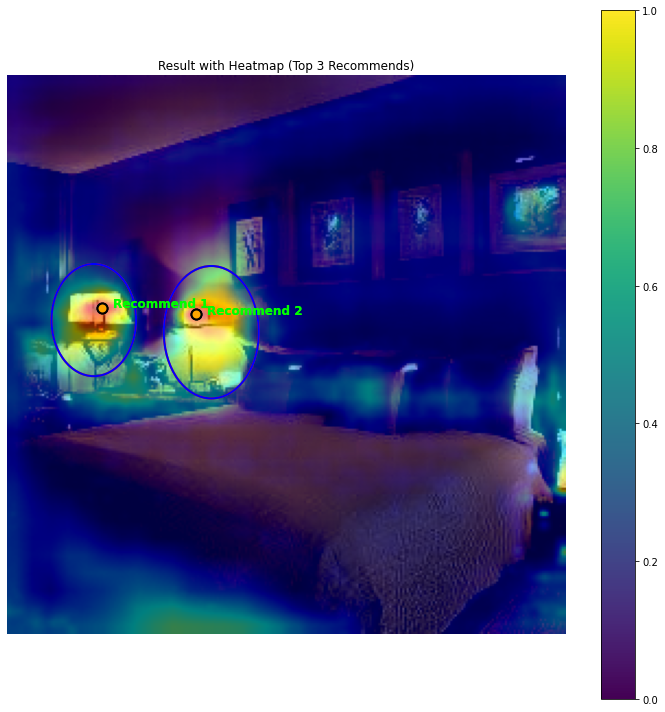

In [8]:
exec_inference_dataframe(input_data, model_info)